# Machine Learning with SAP Datasphere, Hands-On Workshop
## Create first forecast

Retrieve the credentials to connect to SAP Datasphere

In [1]:
import json
file = open('credentials.json', 'r')
credentials = json.load(file)
file.close()

Establish a connection with SAP Datasphere

In [2]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(address  = credentials['hana_address'],
                                   port     = credentials['hana_port'], 
                                   user     = credentials['hana_user'], 
                                   password = credentials['hana_password'], 
                                  )
conn.connection.isconnected()

True

Point a hana_ml DataFrame to the view in SAP Datasphere, which was created in the previous notebook

In [3]:
df_remote = conn.table('V2_LUCERNEELECTRICITY')

Retrieve and display a few rows of data from SAP Datasphere

In [4]:
df_remote.head(5).collect()

,DATEHOUR,CONSUMPTION_H,HOUR
0,2022-01-01 00:00:00,92495.637419999815,0
1,2022-01-01 01:00:00,76818.075419999825,1
2,2022-01-01 02:00:00,74258.551919999835,2
3,2022-01-01 03:00:00,68339.550919999829,3
4,2022-01-01 04:00:00,63413.690919999855,4


Split the data into training and test set. This will allow to train the Machine Learning model on one part of the data (df_rem_train) and to test the accuracy of its forecast on the test data (df_rem_test).

In [5]:
df_rem_train = df_remote.filter('''DATEHOUR > '2022-01-01' AND "DATEHOUR" < '2023-06-25'  ''')
df_rem_test = df_remote.filter('''"DATEHOUR" >='2023-06-25' AND DATEHOUR < '2023-06-27' ''')

Train the Machine Learning model on the training data. We use the AdditiveModelForecast algorithm, which is part of the Predictive Analysis Library in SAP HANA Cloud. This algorithm uses the same concept as Facebook's Prophet algorithm, which is very popular for time series forecasts. See the documentation on https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2023_2_QRC/en-US/pal/algorithms/hana_ml.algorithms.pal.tsa.additive_model_forecast.AdditiveModelForecast.html

In [6]:
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast
amf = AdditiveModelForecast()
amf.fit(data=df_rem_train.drop('HOUR'))

Look at the trained model

In [7]:
import json
json.loads(amf.model_.select('MODEL_CONTENT').collect().iloc[0,0])

{'GROWTH': 'linear',
 'FLOOR': 0.0,
 'SEASONALITY_MODE': 'additive',
 'start': '2022-01-01 01:00:00.0000000',
 'y_scale': 1097249.4687720018,
 't_scale': 46648800.0,
 'cat_field_moments': '',
 'seasonality_name': [['daily', 'weekly']],
 'seasonality_period': [[1.0, 7.0]],
 'seasonality_fourier_order': [[4.0, 3.0]],
 'seasonality_prior_scale': [[10.0, 10.0]],
 'seasonality_mode': [[0, 0]],
 'k': 0.1321508552035316,
 'm': 0.061146124244456534,
 'delta': [[-0.19023908016361168,
   -0.041528475478819354,
   -0.0004574799366457032,
   -0.0158028391376639,
   -0.00688958671301197,
   5.396312253514689e-05,
   0.009485917918803046,
   0.052304131474375785,
   0.0001816350415940325,
   -0.0007464379650221476,
   -0.00020536827712468547,
   0.0872781839000994,
   0.11088310735720784,
   0.0041607621491784085,
   -4.0510155153982324e-05,
   -0.1168933833704492,
   1.3797242630358217e-05,
   0.29431287961810615,
   0.00804073144565246,
   -0.3244888192551261,
   0.3762506292904484,
   -0.13168914

Predict the consumption for the time period of the test dataset

In [8]:
df_rem_predicted = amf.predict(data=df_rem_test)
df_rem_predicted.head(5).collect()

,DATEHOUR,YHAT,YHAT_LOWER,YHAT_UPPER
0,2023-06-25 00:00:00,49407.541110,18808.516650,82295.729669
1,2023-06-25 01:00:00,49876.170444,18885.126832,83645.999487
2,2023-06-25 02:00:00,46101.611325,13341.872397,76005.377821
3,2023-06-25 03:00:00,39852.418956,7116.886547,73219.664507
4,2023-06-25 04:00:00,33628.329482,1750.209455,68007.647124


Combine the known consumption of the test data with the prediction to assess the forecast accurarcy.

In [9]:
df_rem_predicted = df_rem_test.set_index('DATEHOUR').join(df_rem_predicted.set_index('DATEHOUR'))
df_rem_predicted.head(5).collect()

,DATEHOUR,CONSUMPTION_H,HOUR,YHAT,YHAT_LOWER,YHAT_UPPER
0,2023-06-25 00:00:00,56622.986472000002,0,49407.541110,18808.516650,82295.729669
1,2023-06-25 01:00:00,59822.318222000008,1,49876.170444,18885.126832,83645.999487
2,2023-06-25 02:00:00,34783.877045000003,2,46101.611325,13341.872397,76005.377821
3,2023-06-25 03:00:00,27965.448171,3,39852.418956,7116.886547,73219.664507
4,2023-06-25 04:00:00,27491.068442999999,4,33628.329482,1750.209455,68007.647124


Plot the predicted values versus the actual values to visually compare the actuals with the forecast.

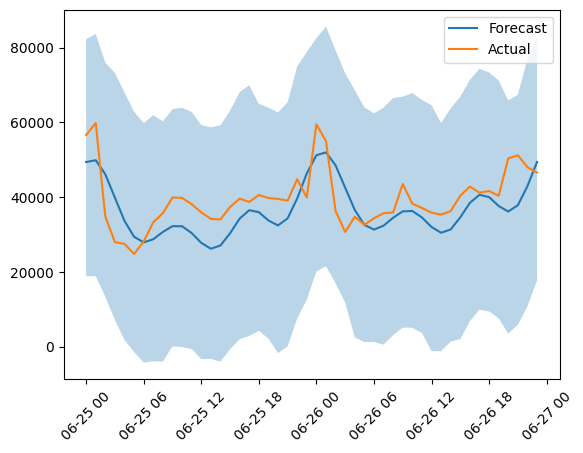

In [10]:
df_data = df_rem_predicted.sort("DATEHOUR").collect()

from matplotlib import pyplot as plt
plt.plot(df_data['DATEHOUR'], df_data['YHAT'])
plt.plot(df_data['DATEHOUR'], df_data['CONSUMPTION_H'])
plt.fill_between(df_data['DATEHOUR'],df_data['YHAT_LOWER'], df_data['YHAT_UPPER'], alpha=.3)
plt.legend(['Forecast', 'Actual'])
plt.xticks(rotation=45);

Calculate an error metrics. We ask for the MAPE, which stands for "Median Absolute Percentage Error". Other error metrics are listed in https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2023_2_QRC/en-US/pal/algorithms/hana_ml.algorithms.pal.tsa.accuracy_measure.accuracy_measure.html

In [11]:
from hana_ml.algorithms.pal.tsa.accuracy_measure import accuracy_measure
accuracy_measure(df_rem_predicted.select(['CONSUMPTION_H', 'YHAT']),
evaluation_metric='mape').collect()

,STAT_NAME,STAT_VALUE
0,MAPE,0.148794


Combine the training dataset with the predicted data. This UNION of hana_ml DataFrames requires both to have the same structure. Hence the training data is extended to also contains the columns that hold the predictions.

In [12]:
df_rem_train = df_rem_train.select('*', ('NULL', 'YHAT'),
                                  ('NULL', 'YHAT_LOWER'),
                                  ('NULL', 'YHAT_UPPER')
                                  )
df_rem_all = df_rem_predicted.union(df_rem_train)
df_rem_all.head(5).collect()

,DATEHOUR,CONSUMPTION_H,HOUR,YHAT,YHAT_LOWER,YHAT_UPPER
0,2023-06-25 18:00:00,40567.730688000001,18,35987.704026,4210.513970,64942.670809
1,2023-06-25 13:00:00,34188.225704000005,13,26186.681896,-3283.494215,58691.688169
2,2023-06-26 23:00:00,46589.115436000008,23,49422.343359,17724.189242,82777.516654
3,2023-06-25 01:00:00,59822.318222000008,1,49876.170444,18885.126832,83645.999487
4,2023-06-26 02:00:00,36312.268657000001,2,48504.820776,16958.115239,79265.015396


Save the combined dataset as physical table to SAP Datasphere

In [13]:
df_rem_all.save('LUCERNEELECTRICITY_FORECAST', force=True)